In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

Using TensorFlow backend.


### Load Data

In [2]:
(X_Train,_), (_,_) = mnist.load_data()

print(X_Train.shape)

(60000, 28, 28)


In [3]:
X_Train = X_Train.reshape((*X_Train.shape, 1))
print(X_Train.shape)

(60000, 28, 28, 1)


### Normalize The Data

In [4]:
X_Train = (X_Train.astype('float32') - 127.5)/127.5
print(np.min(X_Train))
print(np.max(X_Train))
print(X_Train.shape)

-1.0
1.0
(60000, 28, 28, 1)


### Defining Some Parameters

In [5]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)
NOISE_DIM = 100 # Upsample This Into 784 Dim Vector Later
adam = Adam(lr=2e-4, beta_1=0.5)

### Generator

#### Learnable Upsampling By Using Transpose Convolution 

In [6]:
# Start From (7 x 7 x 128)
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(NOISE_DIM,))) # Upsampling The Noise
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Double The Activation Size (14 x 14 x 64)
generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Double The Activation Size (28 x 28 x 1)
generator.add(Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)       

### Discriminator

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))
# Next Conv Layer (14 x 14 x 64) --> (7 x 7 x 128)
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
# Flatten
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

### Building The Complete GAN Model By Combining Generator And Discriminator

In [8]:
# GAN (Step-2)

discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,)) # Acts As A Placeholder
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input, gan_output)
model.compile(loss='binary_crossentropy', optimizer=adam)
# Discriminator Weights Are Only Frozen For This
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


### Function To Visualise & Save Output Images

In [9]:
def save_imgs(epoch, samples=100):
    noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples, 28, 28)
    
    plt.figure(figsize=(15,15))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i], interpolation='nearest', cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("DCGAN_TransposeConv_Images/DCGAN_Output_Epoch_{}.png".format(epoch+1))
    plt.show()

### Training Loop (Two Step Process)

Epoch 1 ! Discriminator Loss = 0.1983 & Generator Loss = 0.0889
Epoch 2 ! Discriminator Loss = 0.4795 & Generator Loss = 1.2447
Epoch 3 ! Discriminator Loss = 0.6597 & Generator Loss = 0.9700
Epoch 4 ! Discriminator Loss = 0.6246 & Generator Loss = 1.0482
Epoch 5 ! Discriminator Loss = 0.6499 & Generator Loss = 1.0277


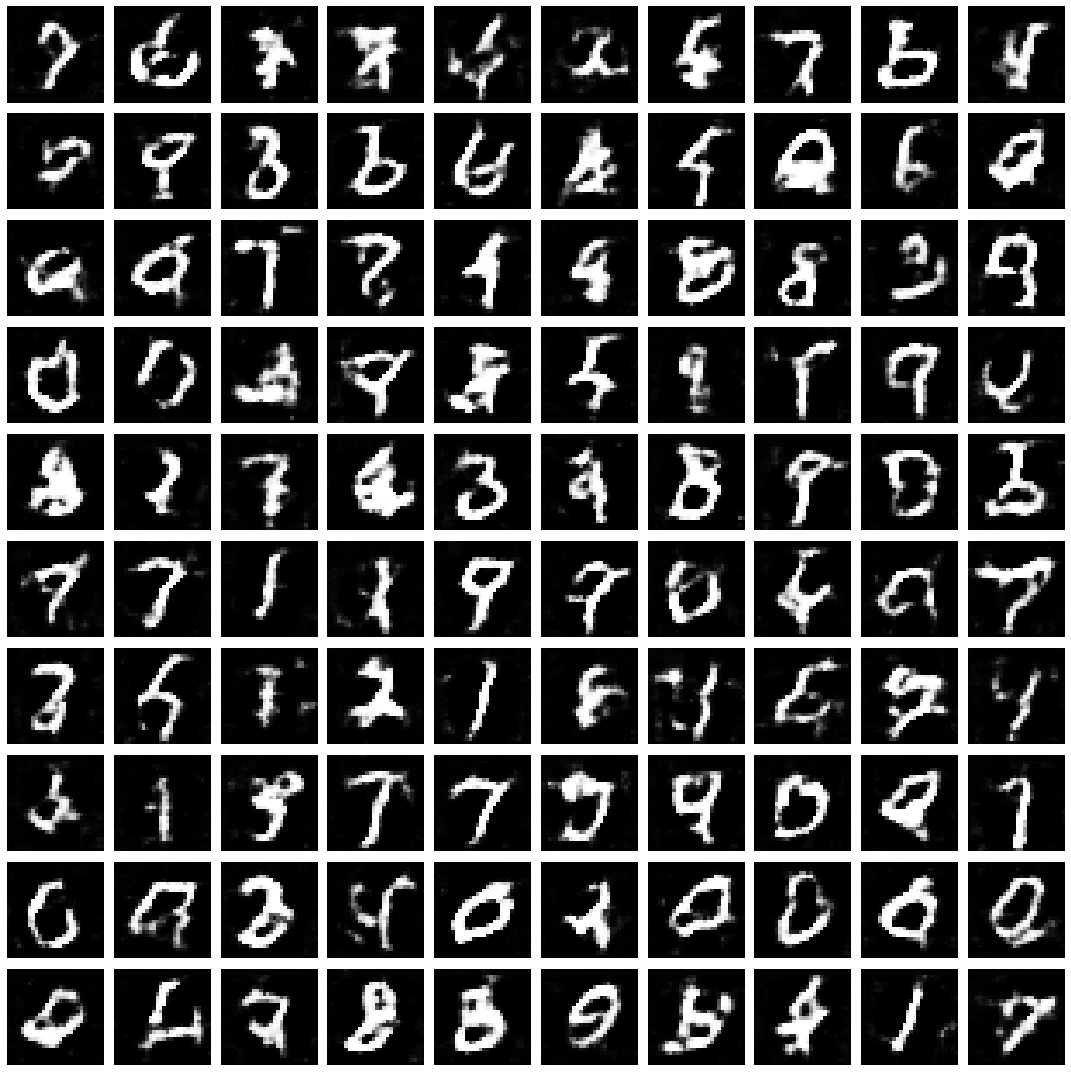

Epoch 6 ! Discriminator Loss = 0.6734 & Generator Loss = 0.9692
Epoch 7 ! Discriminator Loss = 0.6803 & Generator Loss = 0.9369
Epoch 8 ! Discriminator Loss = 0.6837 & Generator Loss = 0.9148
Epoch 9 ! Discriminator Loss = 0.6821 & Generator Loss = 0.9179
Epoch 10 ! Discriminator Loss = 0.6811 & Generator Loss = 0.9022


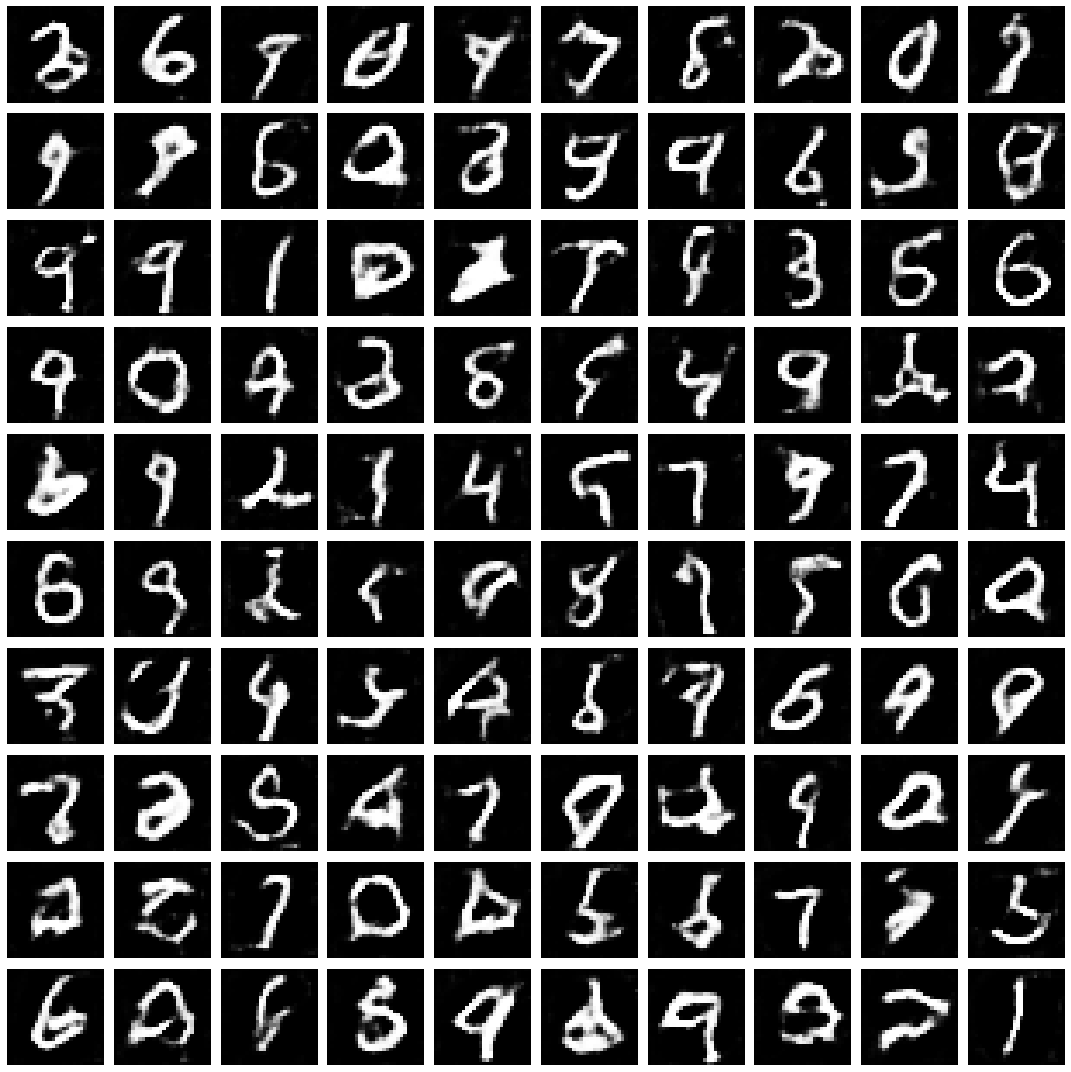

Epoch 11 ! Discriminator Loss = 0.6786 & Generator Loss = 0.9208
Epoch 12 ! Discriminator Loss = 0.6776 & Generator Loss = 0.8997
Epoch 13 ! Discriminator Loss = 0.6770 & Generator Loss = 0.9083
Epoch 14 ! Discriminator Loss = 0.6749 & Generator Loss = 0.9183
Epoch 15 ! Discriminator Loss = 0.6755 & Generator Loss = 0.9052


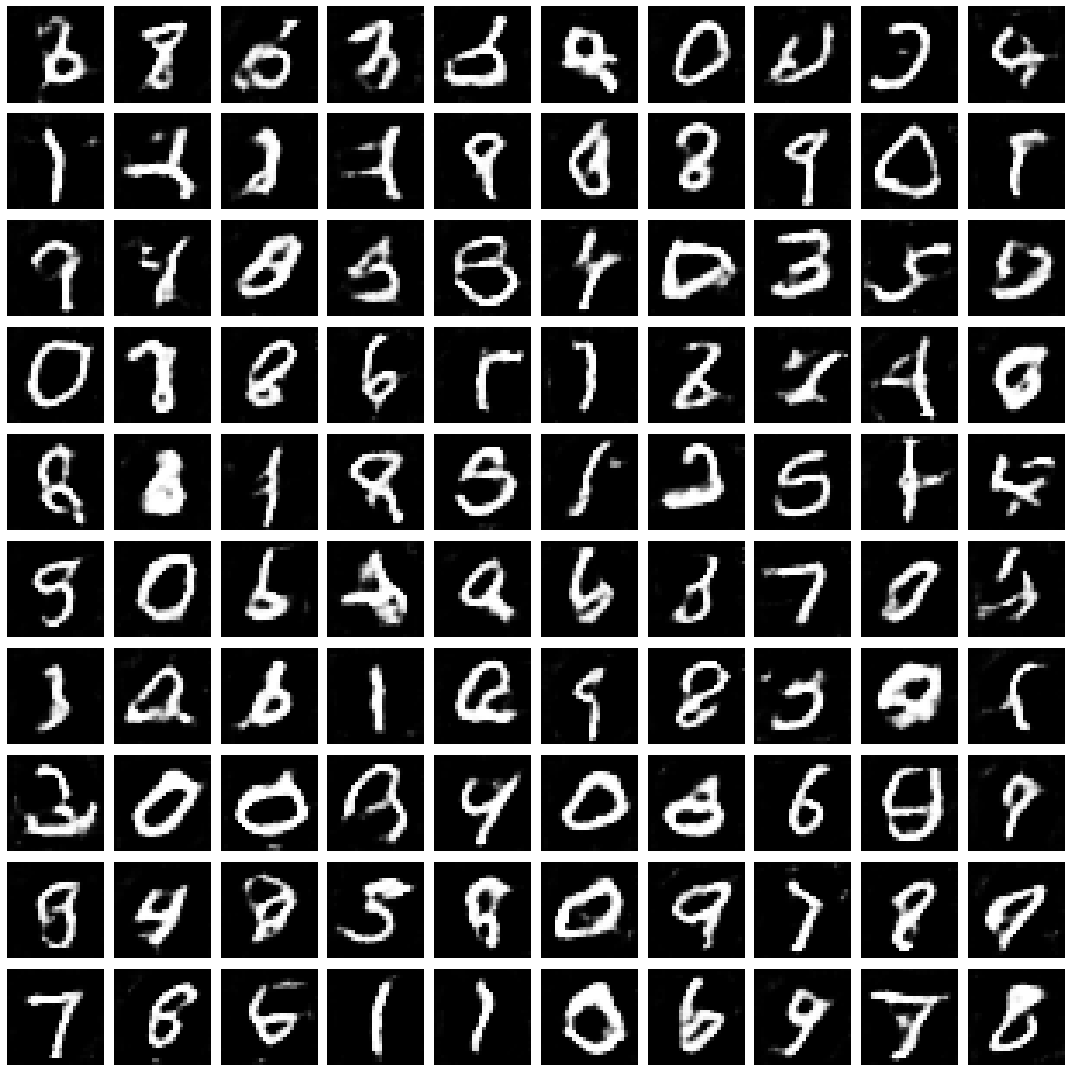

Epoch 16 ! Discriminator Loss = 0.6757 & Generator Loss = 0.9077
Epoch 17 ! Discriminator Loss = 0.6750 & Generator Loss = 0.9061
Epoch 18 ! Discriminator Loss = 0.6731 & Generator Loss = 0.9211
Epoch 19 ! Discriminator Loss = 0.6726 & Generator Loss = 0.9092
Epoch 20 ! Discriminator Loss = 0.6724 & Generator Loss = 0.9167


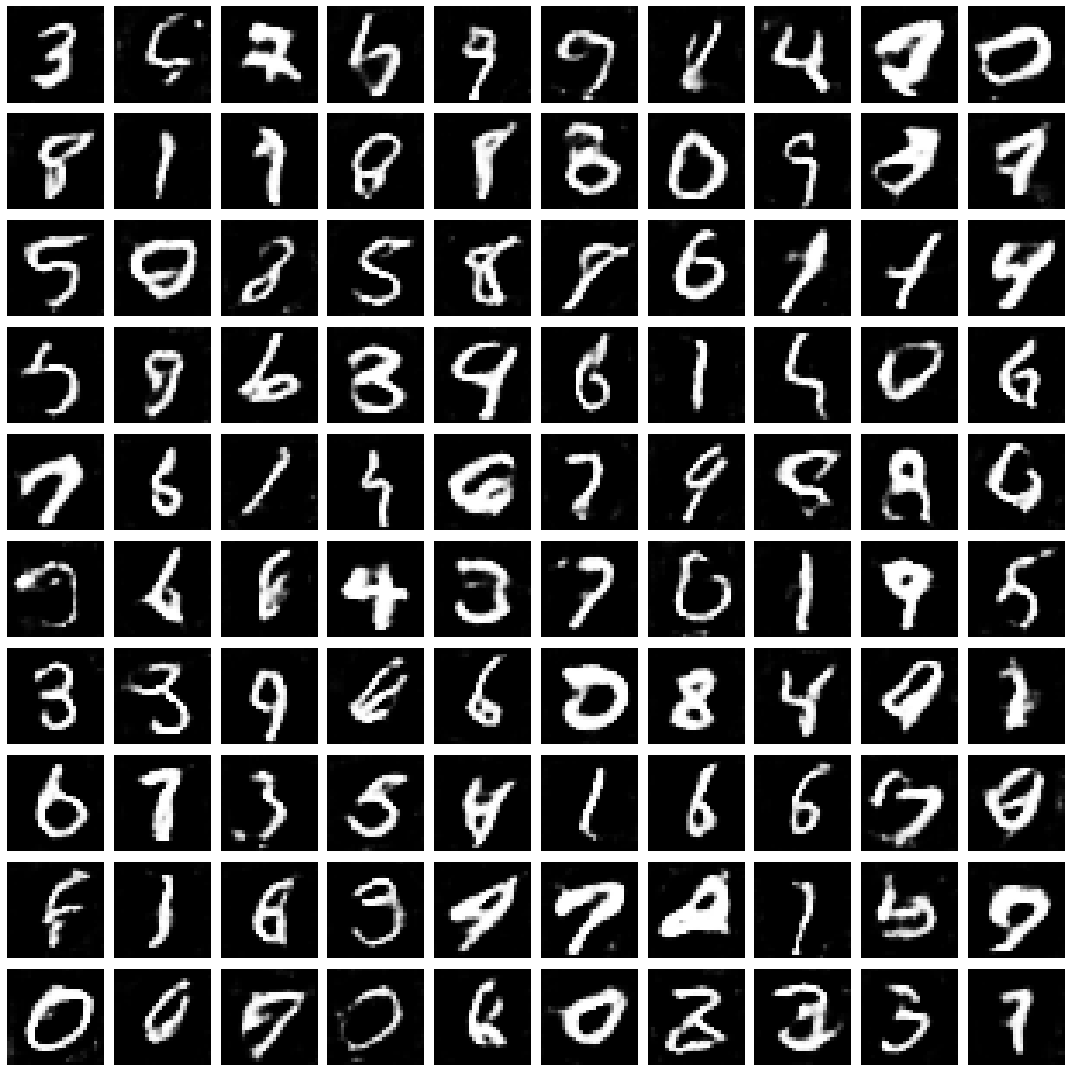

Epoch 21 ! Discriminator Loss = 0.6717 & Generator Loss = 0.9188
Epoch 22 ! Discriminator Loss = 0.6707 & Generator Loss = 0.9223
Epoch 23 ! Discriminator Loss = 0.6704 & Generator Loss = 0.9194
Epoch 24 ! Discriminator Loss = 0.6698 & Generator Loss = 0.9244
Epoch 25 ! Discriminator Loss = 0.6686 & Generator Loss = 0.9299


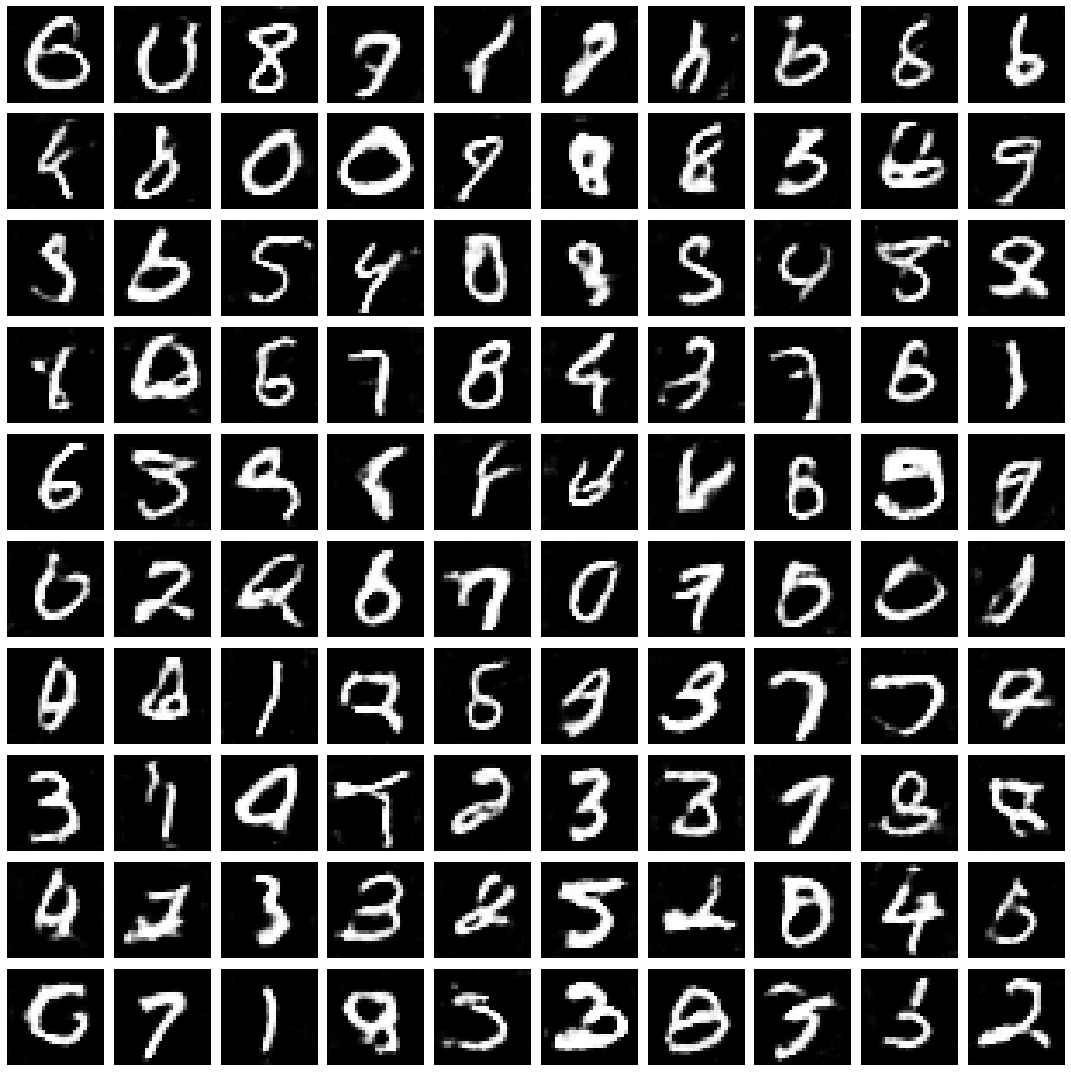

Epoch 26 ! Discriminator Loss = 0.6678 & Generator Loss = 0.9285
Epoch 27 ! Discriminator Loss = 0.6677 & Generator Loss = 0.9350
Epoch 28 ! Discriminator Loss = 0.6661 & Generator Loss = 0.9378
Epoch 29 ! Discriminator Loss = 0.6656 & Generator Loss = 0.9395
Epoch 30 ! Discriminator Loss = 0.6658 & Generator Loss = 0.9407


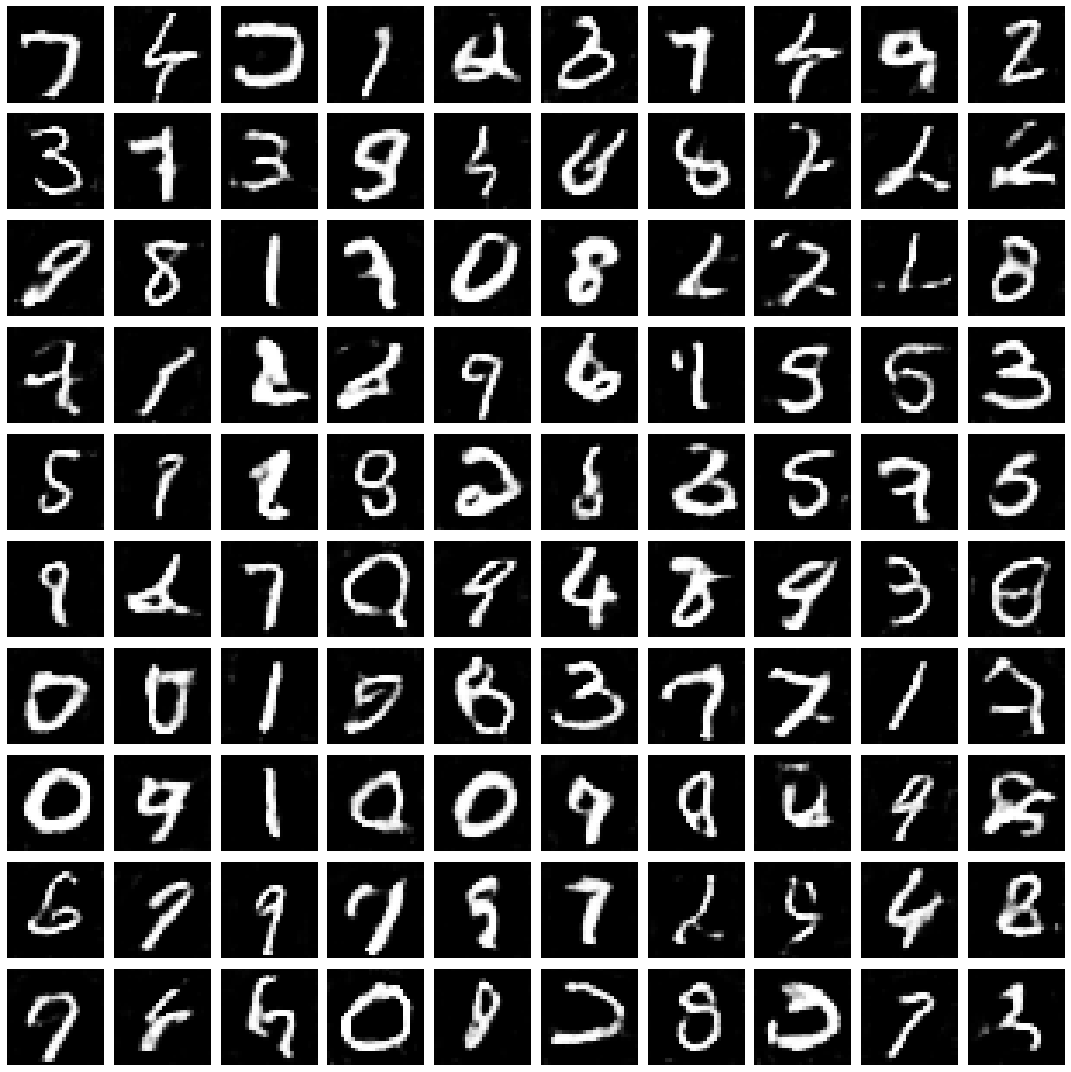

Epoch 31 ! Discriminator Loss = 0.6647 & Generator Loss = 0.9421
Epoch 32 ! Discriminator Loss = 0.6638 & Generator Loss = 0.9493
Epoch 33 ! Discriminator Loss = 0.6630 & Generator Loss = 0.9517
Epoch 34 ! Discriminator Loss = 0.6633 & Generator Loss = 0.9520
Epoch 35 ! Discriminator Loss = 0.6616 & Generator Loss = 0.9580


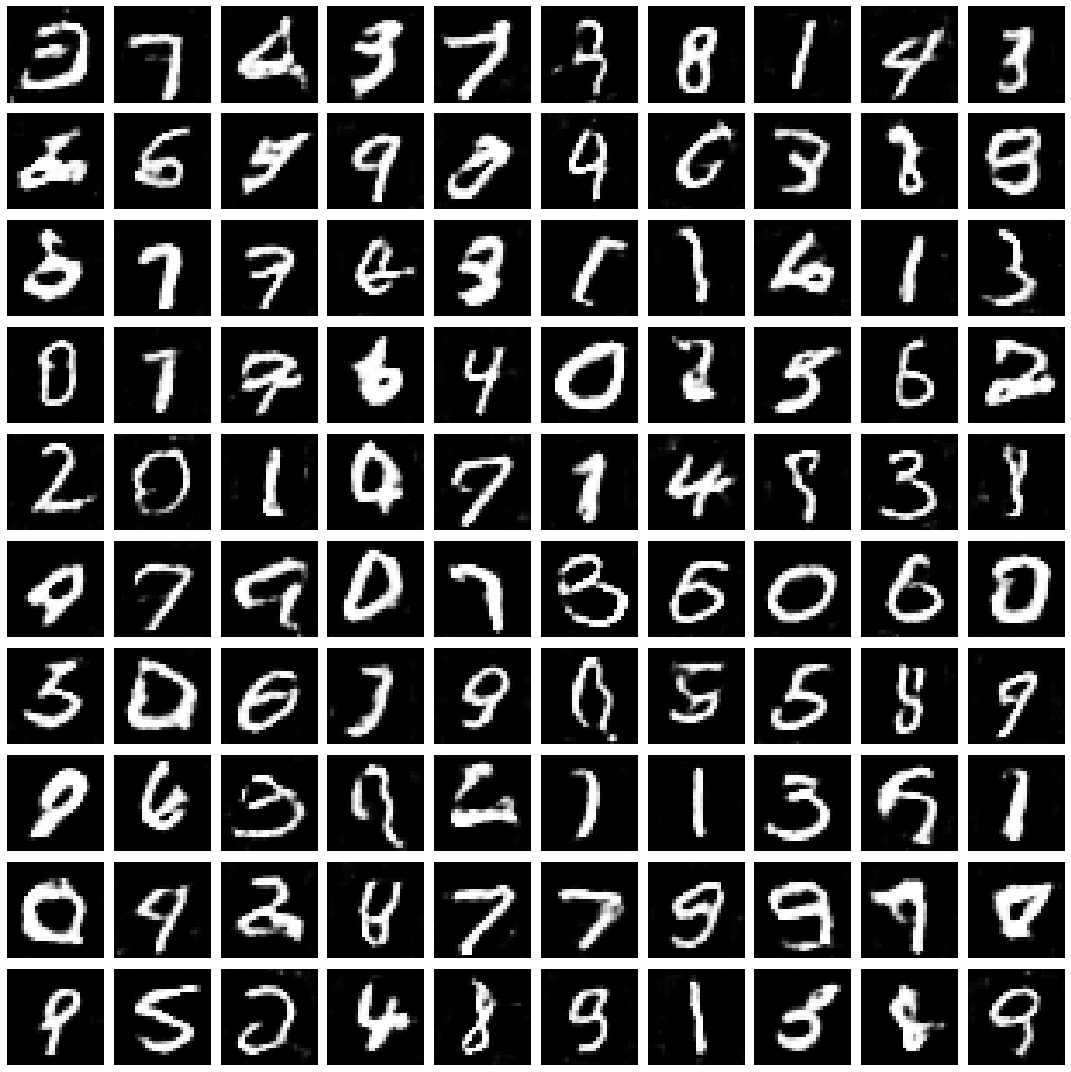

Epoch 36 ! Discriminator Loss = 0.6616 & Generator Loss = 0.9653
Epoch 37 ! Discriminator Loss = 0.6595 & Generator Loss = 0.9614
Epoch 38 ! Discriminator Loss = 0.6591 & Generator Loss = 0.9685
Epoch 39 ! Discriminator Loss = 0.6592 & Generator Loss = 0.9695
Epoch 40 ! Discriminator Loss = 0.6574 & Generator Loss = 0.9777


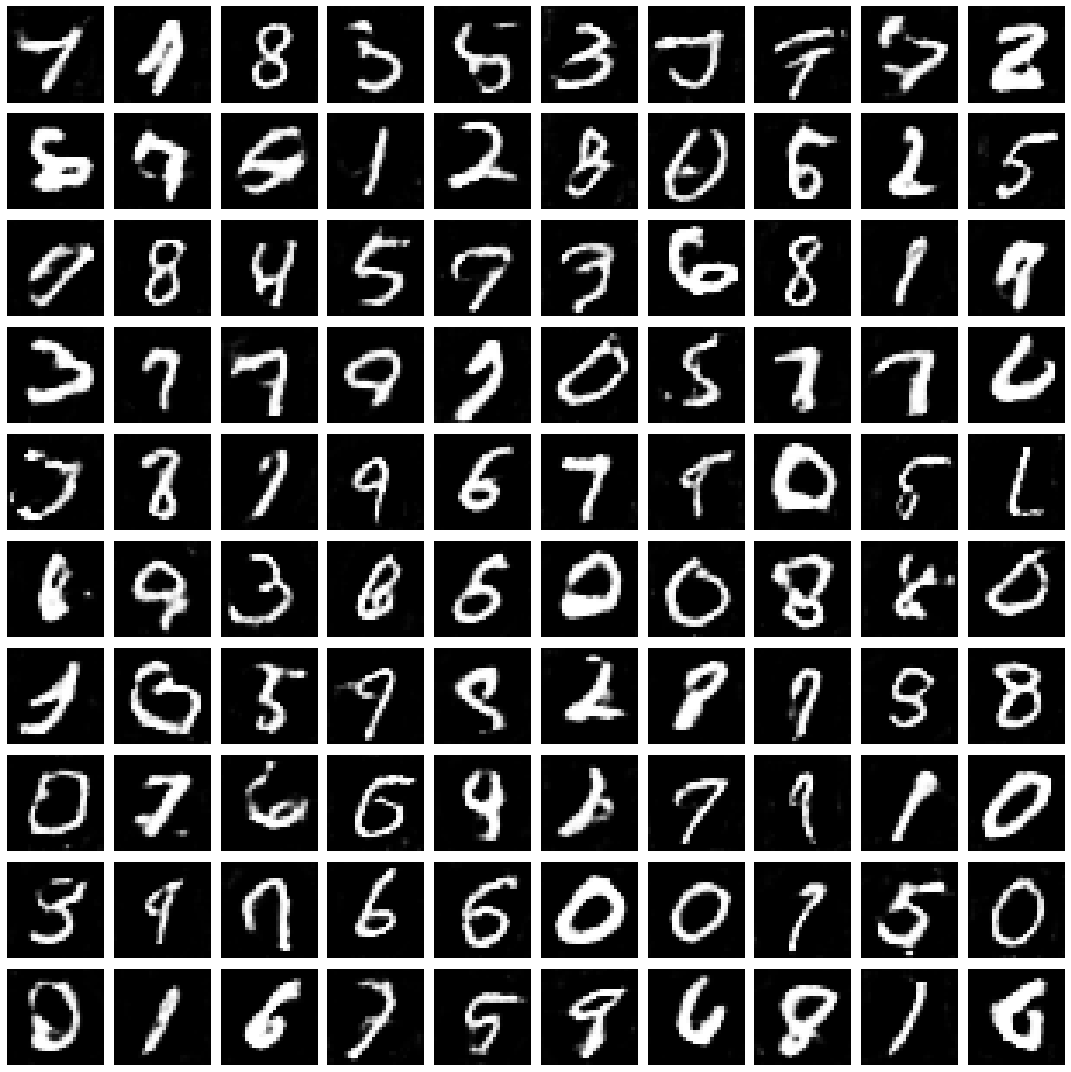

Epoch 41 ! Discriminator Loss = 0.6569 & Generator Loss = 0.9803
Epoch 42 ! Discriminator Loss = 0.6567 & Generator Loss = 0.9815
Epoch 43 ! Discriminator Loss = 0.6569 & Generator Loss = 0.9871
Epoch 44 ! Discriminator Loss = 0.6537 & Generator Loss = 0.9907
Epoch 45 ! Discriminator Loss = 0.6531 & Generator Loss = 0.9947


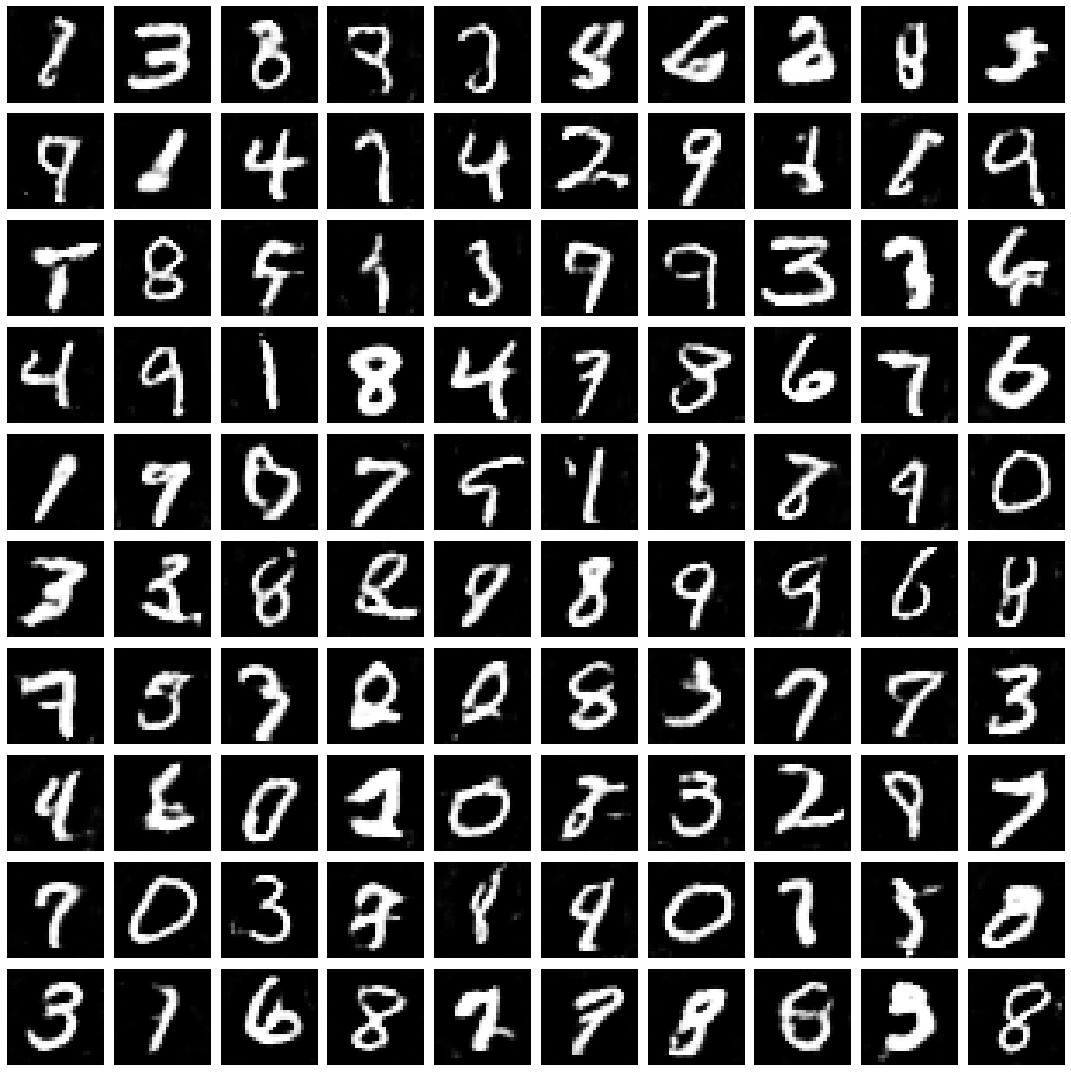

Epoch 46 ! Discriminator Loss = 0.6535 & Generator Loss = 0.9957
Epoch 47 ! Discriminator Loss = 0.6521 & Generator Loss = 0.9998
Epoch 48 ! Discriminator Loss = 0.6513 & Generator Loss = 1.0038
Epoch 49 ! Discriminator Loss = 0.6512 & Generator Loss = 1.0101
Epoch 50 ! Discriminator Loss = 0.6502 & Generator Loss = 1.0130


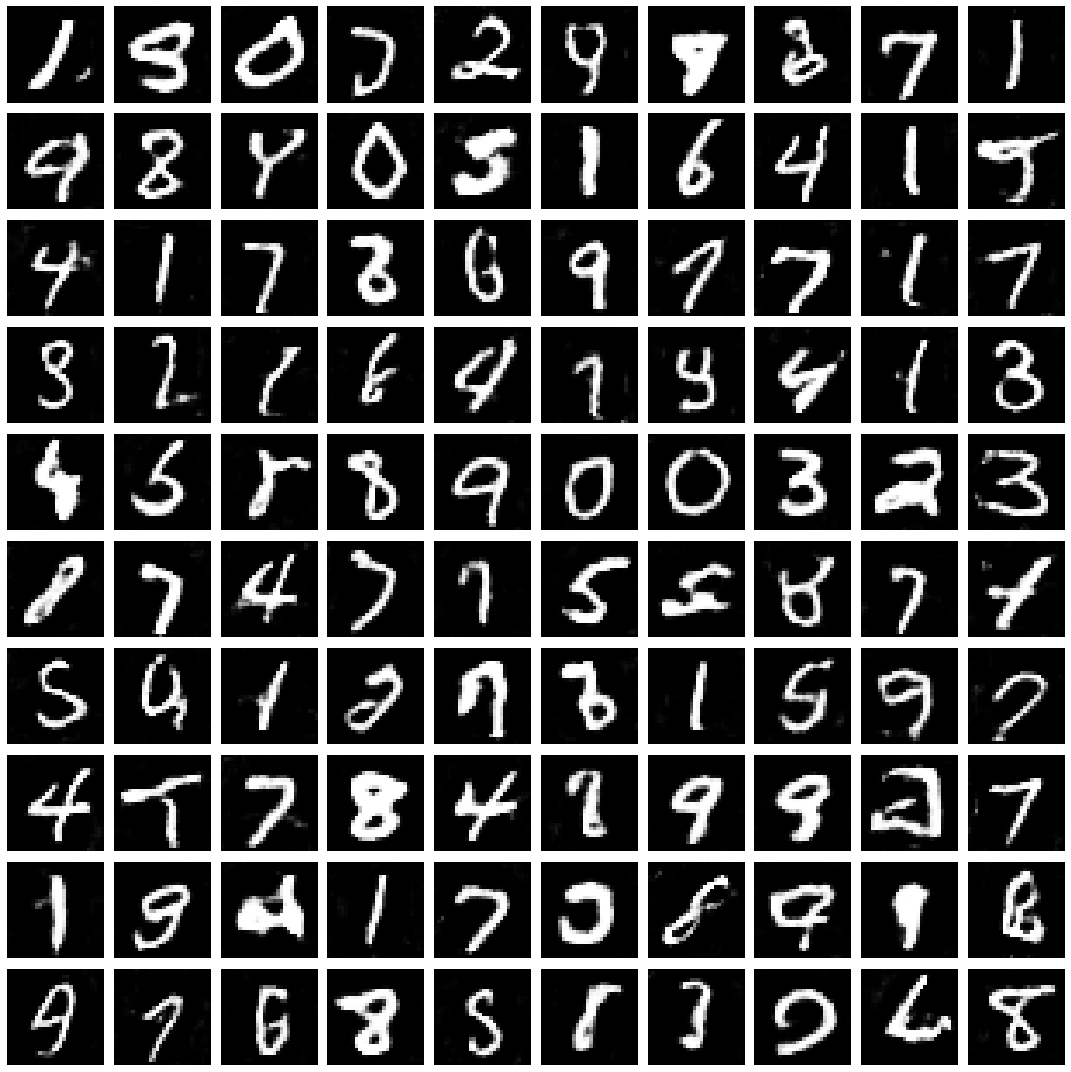

In [10]:
d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.0 
    epoch_g_loss = 0.0
    
    # Mini Batch SGD (Mini Batch Stochastic Gradient Descent)
    for step in range(NO_OF_BATCHES):
        
        # Step-1 Train Discriminator
        # 50% Real Data + 50% Fake Data
        
        # Real Data X
        idx = np.random.randint(0, X_Train.shape[0], HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        
        # Fake Data X
        noise = np.random.normal(0, 1, size=(HALF_BATCH_SIZE, NOISE_DIM))
        fake_imgs = generator.predict(noise) # Forward Pass
        
        # Labels
        real_y = np.ones((HALF_BATCH_SIZE,1)) * 0.9 # One Sided Label Smoothing For Discriminator
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # Train Our Discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)
        
        epoch_d_loss += d_loss
        
        # Step-2 Train Generator (Considering Frozen Discriminator)
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE, 1))
        g_loss = model.train_on_batch(noise, ground_truth_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d ! Discriminator Loss = %.4f & Generator Loss = %.4f"%((epoch+1), (epoch_d_loss/NO_OF_BATCHES), (epoch_g_loss/NO_OF_BATCHES)))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    if((epoch+1)%5 == 0):
        generator.save("DCGAN_TransposeConv_Models/dcgan_generator_{}.h5".format(epoch+1))
        save_imgs(epoch)

### Plotting The Losses

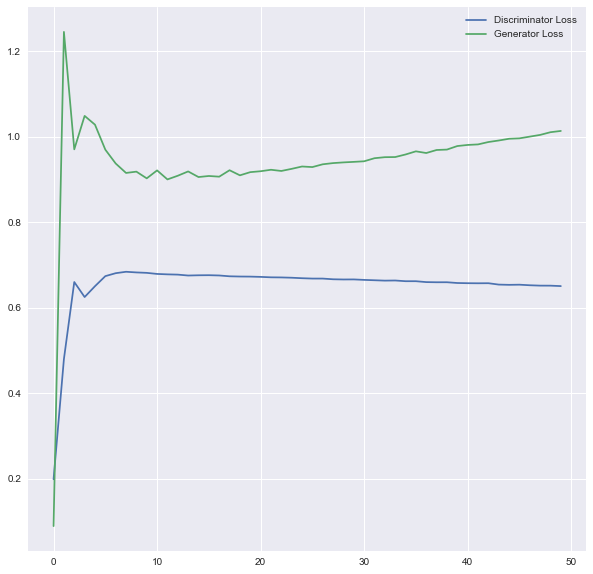

In [11]:
plt.style.use("seaborn")
plt.figure(figsize=(10,10))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.legend()
plt.show()